# Setup

In [ ]:
# ================================================================================
# CÉLULA 1: INSTALAÇÃO
# ================================================================================
%pip install tabm rtdl_num_embeddings optuna

In [26]:
# ================================================================================
# CÉLULA 2: IMPORTS E CONFIGURAÇÕES
# ================================================================================
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, auc
import warnings
import matplotlib.pyplot as plt
import optuna

try:
    from tabm import TabM
    from rtdl_num_embeddings import PiecewiseLinearEmbeddings, LinearReLUEmbeddings
    print("TabM e rtdl_num_embeddings importados com sucesso!")
except ImportError:
    print("Bibliotecas não encontradas. Execute a célula de instalação acima e reinicie o kernel se necessário.")

warnings.filterwarnings('ignore')

# Configurações
N_SPLITS = 10
RANDOM_STATE = 42
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Usando dispositivo: {DEVICE}")

# URL do dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"

# Nomes das colunas
columns = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 
           'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']

TabM e rtdl_num_embeddings importados com sucesso!
Usando dispositivo: cpu


In [27]:
# ================================================================================
# CÉLULA 4: DEFINIÇÃO DO MODELO E FUNÇÕES DE TREINAMENTO
# ================================================================================
import rtdl_num_embeddings

def create_tabm_model(n_num_features, cat_cardinalities, params, X_train=None, d_out=1):
    """
    Cria o modelo TabM com hiperparâmetros dinâmicos.
    Adiciona suporte a Embeddings Numéricos se especificado.
    """
    
    # Configuração de Embeddings Numéricos (Opcional mas recomendado)
    num_embeddings = None
    if params.get('use_embeddings', False) and X_train is not None:
        # Usando PiecewiseLinearEmbeddings com cálculo de bins
        bins = rtdl_num_embeddings.compute_bins(X_train, n_bins=params['n_bins'])
        
        num_embeddings = PiecewiseLinearEmbeddings(
            bins=bins,
            d_embedding=params['d_embedding'],
            activation=False, # Geralmente False para TabM
            version='B'
        )

    model = TabM.make(
        n_num_features=n_num_features,
        cat_cardinalities=cat_cardinalities,
        d_out=d_out,
        n_blocks=params['n_blocks'],
        d_block=params['d_block'],
        dropout=params.get('dropout', 0.1),
        num_embeddings=num_embeddings
    )
    return model

def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    
    for X_num_batch, X_cat_batch, y_batch in loader:
        X_num_batch, X_cat_batch, y_batch = X_num_batch.to(device), X_cat_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        y_pred = model(X_num_batch, X_cat_batch)
        
        # Loss média das k predições independentes
        y_target_expanded = y_batch.unsqueeze(1).expand(-1, model.k, -1)
        loss = criterion(y_pred.reshape(-1, 1), y_target_expanded.reshape(-1, 1))
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * X_num_batch.size(0)
        
    return total_loss / len(loader.dataset)

def evaluate(model, loader, device):
    model.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for X_num_batch, X_cat_batch, y_batch in loader:
            X_num_batch, X_cat_batch = X_num_batch.to(device), X_cat_batch.to(device)
            
            # Ensemble mean na inferência
            y_pred = model(X_num_batch, X_cat_batch)
            probs = torch.sigmoid(y_pred).mean(dim=1)
            
            all_preds.append(probs.cpu().numpy())
            all_targets.append(y_batch.numpy())
            
    return np.vstack(all_preds), np.vstack(all_targets)

In [28]:
# ================================================================================
# CÉLULA 5: OTIMIZAÇÃO DE HIPERPARÂMETROS (OPTUNA)
# ================================================================================
import json
import os

def objective(trial):
    # Espaço de busca sugerido na documentação do TabM
    params = {
        'n_blocks': trial.suggest_int('n_blocks', 1, 4), 
        'd_block': trial.suggest_int('d_block', 64, 512, step=16), 
        'lr': trial.suggest_float('lr', 1e-4, 5e-3, log=True),
        'weight_decay': trial.suggest_float('weight_decay', 1e-5, 1e-1, log=True),
        'dropout': trial.suggest_float('dropout', 0.0, 0.5),
        
        # Configurações de Embeddings
        'use_embeddings': True,
        'd_embedding': trial.suggest_int('d_embedding', 8, 32, step=4),
        'n_bins': trial.suggest_int('n_bins', 2, 64)
    }
    
    # Validação cruzada interna (3 folds para ser rápido)
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
    scores = []
    
    for train_idx, val_idx in skf.split(X_num, y):
        # Split simples
        X_num_train, X_num_val = X_num[train_idx], X_num[val_idx]
        X_cat_train, X_cat_val = X_cat[train_idx], X_cat[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        train_ds = TensorDataset(torch.tensor(X_num_train), torch.tensor(X_cat_train), torch.tensor(y_train))
        val_ds = TensorDataset(torch.tensor(X_num_val), torch.tensor(X_cat_val), torch.tensor(y_val))
        
        train_loader = DataLoader(train_ds, batch_size=256, shuffle=True)
        val_loader = DataLoader(val_ds, batch_size=256, shuffle=False)
        
        # Passar X_num_train para calcular os bins dos embeddings
        model = create_tabm_model(
            len(feature_names_num), 
            cat_cardinalities, 
            params, 
            X_train=torch.tensor(X_num_train)
        ).to(DEVICE)
        
        optimizer = optim.AdamW(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])
        criterion = nn.BCEWithLogitsLoss()
        
        # Treino curto (30 épocas)
        best_fold_auc = 0
        for epoch in range(30):
            train_epoch(model, train_loader, optimizer, criterion, DEVICE)
            val_preds, val_targets = evaluate(model, val_loader, DEVICE)
            try:
                auc = roc_auc_score(val_targets, val_preds)
            except:
                auc = 0.5
            best_fold_auc = max(best_fold_auc, auc)
            
            # Pruning do Optuna
            trial.report(best_fold_auc, epoch)
            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()
                
        scores.append(best_fold_auc)
    
    return np.mean(scores)

print("Iniciando estudo de otimização...")
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100) 

print("\nMelhores hiperparâmetros:")
best_params = study.best_params
best_params['use_embeddings'] = True 
print(best_params)

# Salvar em JSON
output_dir = '/home/matheus/ifpe/tcc/v4/mvp-heart-disease-function/TabM'
os.makedirs(output_dir, exist_ok=True)
json_path = os.path.join(output_dir, 'best_params_tabm.json')

with open(json_path, 'w') as f:
    json.dump(best_params, f, indent=4)
    
print(f"Melhores parâmetros salvos em: {json_path}")

[I 2025-12-02 14:43:53,347] A new study created in memory with name: no-name-fe557ae8-ffef-4459-a2bc-5651312eac56


Iniciando estudo de otimização...


[I 2025-12-02 14:43:56,027] Trial 0 finished with value: 0.8986352347547012 and parameters: {'n_blocks': 2, 'd_block': 96, 'lr': 0.0008796312471633003, 'weight_decay': 0.0010562533504149632, 'dropout': 0.10624408518818895, 'd_embedding': 32, 'n_bins': 8}. Best is trial 0 with value: 0.8986352347547012.
[I 2025-12-02 14:43:59,622] Trial 1 finished with value: 0.899859900005739 and parameters: {'n_blocks': 1, 'd_block': 256, 'lr': 0.003358802554833864, 'weight_decay': 0.017827934742785528, 'dropout': 0.3441275048623721, 'd_embedding': 24, 'n_bins': 47}. Best is trial 1 with value: 0.899859900005739.
[I 2025-12-02 14:44:07,882] Trial 2 finished with value: 0.9135269076386567 and parameters: {'n_blocks': 2, 'd_block': 368, 'lr': 0.001861788812048828, 'weight_decay': 0.00048445996779637653, 'dropout': 0.21453480759479693, 'd_embedding': 28, 'n_bins': 60}. Best is trial 2 with value: 0.9135269076386567.
[I 2025-12-02 14:44:13,455] Trial 3 finished with value: 0.9077997999214539 and parameter


Melhores hiperparâmetros:
{'n_blocks': 4, 'd_block': 400, 'lr': 0.003734983534434545, 'weight_decay': 0.009444825973414176, 'dropout': 0.0805118629883789, 'd_embedding': 32, 'n_bins': 23, 'use_embeddings': True}
Melhores parâmetros salvos em: /home/matheus/ifpe/tcc/v4/mvp-heart-disease-function/TabM/best_params_tabm.json



>>> Rodando Experimento Final com Melhores Parâmetros <<<
Fold 1/10
  AUC: 0.9464 | Acc (0.5): 0.7667 | Acc (Opt 0.51): 0.8667
Fold 2/10
  AUC: 0.9732 | Acc (0.5): 0.9000 | Acc (Opt 0.50): 0.9000
Fold 3/10
  AUC: 0.9866 | Acc (0.5): 0.7667 | Acc (Opt 0.49): 0.9333
Fold 4/10
  AUC: 0.8839 | Acc (0.5): 0.6667 | Acc (Opt 0.49): 0.8000
Fold 5/10
  AUC: 0.9554 | Acc (0.5): 0.9000 | Acc (Opt 0.51): 0.8667
Fold 6/10
  AUC: 0.7545 | Acc (0.5): 0.6000 | Acc (Opt 0.50): 0.7000
Fold 7/10
  AUC: 0.9241 | Acc (0.5): 0.8333 | Acc (Opt 0.49): 0.8667
Fold 8/10
  AUC: 0.8798 | Acc (0.5): 0.7931 | Acc (Opt 0.49): 0.7931
Fold 9/10
  AUC: 0.9904 | Acc (0.5): 0.7931 | Acc (Opt 0.47): 0.9310
Fold 10/10
  AUC: 0.9760 | Acc (0.5): 0.7931 | Acc (Opt 0.50): 0.8966


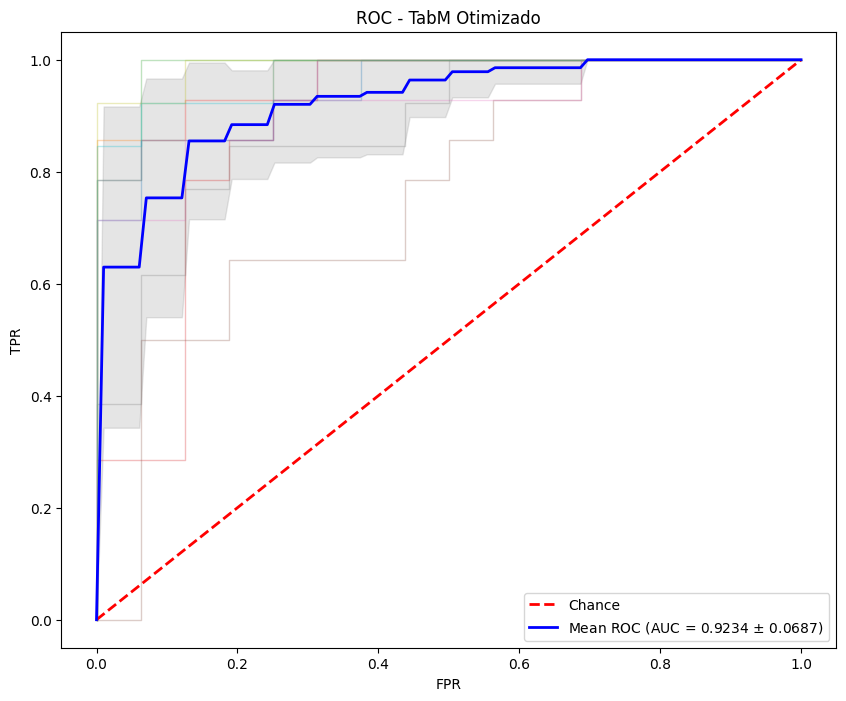


=== RESULTADOS FINAIS ===
Média AUC-ROC: 0.9270 (+/- 0.0687)
Média Accuracy (Threshold 0.5): 0.7813 (+/- 0.0882)
Média Accuracy (Threshold Otimizado): 0.8554 (+/- 0.0685)


In [23]:
# ================================================================================
# CÉLULA 6: EXECUÇÃO DO EXPERIMENTO FINAL (COM THRESHOLD OTIMIZADO)
# ================================================================================
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def run_final_experiment(params):
    print("\n>>> Rodando Experimento Final com Melhores Parâmetros <<<")
    skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
    
    fold_auc_results = []
    fold_acc_results = []
    fold_opt_acc_results = [] # Acurácia com threshold otimizado
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    fig, ax = plt.subplots(figsize=(10, 8))
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_num, y)):
        print(f"Fold {fold+1}/{N_SPLITS}")
        
        X_num_train, X_num_val = X_num[train_idx], X_num[val_idx]
        X_cat_train, X_cat_val = X_cat[train_idx], X_cat[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        train_loader = DataLoader(TensorDataset(torch.tensor(X_num_train), torch.tensor(X_cat_train), torch.tensor(y_train)), batch_size=256, shuffle=True)
        val_loader = DataLoader(TensorDataset(torch.tensor(X_num_val), torch.tensor(X_cat_val), torch.tensor(y_val)), batch_size=256, shuffle=False)
        
        # Passar X_num_train para embeddings
        model = create_tabm_model(
            len(feature_names_num), 
            cat_cardinalities, 
            params, 
            X_train=torch.tensor(X_num_train)
        ).to(DEVICE)
        
        optimizer = optim.AdamW(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])
        criterion = nn.BCEWithLogitsLoss()
        
        best_val_auc = 0
        best_epoch_preds = None
        best_epoch_targets = None
        patience = 15 
        no_improve = 0
        
        for epoch in range(100):
            train_epoch(model, train_loader, optimizer, criterion, DEVICE)
            val_preds, val_targets = evaluate(model, val_loader, DEVICE)
            
            try:
                val_auc = roc_auc_score(val_targets, val_preds)
            except:
                val_auc = 0.5
            
            if val_auc > best_val_auc:
                best_val_auc = val_auc
                best_epoch_preds = val_preds
                best_epoch_targets = val_targets
                no_improve = 0
            else:
                no_improve += 1
                
            if no_improve >= patience:
                break
        
        # Calcular métricas finais para o melhor modelo do fold
        if best_epoch_preds is not None:
            # 1. ROC e Threshold Otimizado (Youden's J)
            fpr, tpr, thresholds = roc_curve(best_epoch_targets, best_epoch_preds)
            J = tpr - fpr
            ix = np.argmax(J)
            best_thresh = thresholds[ix]
            
            # Acurácias
            acc_default = accuracy_score(best_epoch_targets, (best_epoch_preds > 0.5).astype(int))
            acc_opt = accuracy_score(best_epoch_targets, (best_epoch_preds > best_thresh).astype(int))
            
            fold_auc_results.append(best_val_auc)
            fold_acc_results.append(acc_default)
            fold_opt_acc_results.append(acc_opt)
            
            # Plotting
            roc_auc = auc(fpr, tpr)
            aucs.append(roc_auc)
            interp_tpr = np.interp(mean_fpr, fpr, tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            ax.plot(fpr, tpr, lw=1, alpha=0.3)
            
            print(f"  AUC: {best_val_auc:.4f} | Acc (0.5): {acc_default:.4f} | Acc (Opt {best_thresh:.2f}): {acc_opt:.4f}")

    # Plot Média
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance')
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b', label=r'Mean ROC (AUC = %0.4f $\pm$ %0.4f)' % (mean_auc, std_auc), lw=2)
    
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2)
    
    ax.set(title="ROC - TabM Otimizado", xlabel='FPR', ylabel='TPR')
    ax.legend(loc="lower right")
    plt.show()

    print(f"\n=== RESULTADOS FINAIS ===")
    print(f"Média AUC-ROC: {np.mean(fold_auc_results):.4f} (+/- {np.std(fold_auc_results):.4f})")
    print(f"Média Accuracy (Threshold 0.5): {np.mean(fold_acc_results):.4f} (+/- {np.std(fold_acc_results):.4f})")
    print(f"Média Accuracy (Threshold Otimizado): {np.mean(fold_opt_acc_results):.4f} (+/- {np.std(fold_opt_acc_results):.4f})")

if 'best_params' in globals():
    run_final_experiment(best_params)
else:
    print("Execute a célula de otimização primeiro!")

In [ ]:
# ================================================================================
# CÉLULA 7: ESTIMATIVA DE INCERTEZA E IMPORTÂNCIA DE FEATURES
# ================================================================================

def analyze_uncertainty_and_features(model, X_num_val, X_cat_val, y_val, feature_names):
    """
    Analisa a incerteza das predições e a importância das features via permutação.
    """
    print("\n>>> Análise de Incerteza e Features <<<")
    model.eval()
    
    # 1. Incerteza (Desvio Padrão do Ensemble)
    X_num_t = torch.tensor(X_num_val).to(DEVICE)
    X_cat_t = torch.tensor(X_cat_val).to(DEVICE)
    
    with torch.no_grad():
        # Shape: (batch, k, 1)
        y_pred_raw = model(X_num_t, X_cat_t)
        probs_ensemble = torch.sigmoid(y_pred_raw).squeeze(-1).cpu().numpy() # (batch, k)
        
    # Média e Desvio Padrão das probabilidades
    mean_probs = probs_ensemble.mean(axis=1)
    std_probs = probs_ensemble.std(axis=1)
    
    # Plotar relação Probabilidade x Incerteza
    plt.figure(figsize=(10, 6))
    plt.scatter(mean_probs, std_probs, alpha=0.5, c=y_val, cmap='coolwarm')
    plt.colorbar(label='Target Real (0=Azul, 1=Vermelho)')
    plt.title("Incerteza (Std Dev) vs Probabilidade Média")
    plt.xlabel("Probabilidade Média Predita")
    plt.ylabel("Incerteza (Desvio Padrão entre Ensemble)")
    plt.show()
    
    print(f"Incerteza média: {std_probs.mean():.4f}")
    print(f"Exemplo de alta incerteza (Index {np.argmax(std_probs)}): Prob={mean_probs[np.argmax(std_probs)]:.2f}, Std={std_probs.max():.2f}")
    
    # 2. Importância de Features (Permutation Importance)
    print("\nCalculando Importância de Features (Permutação)...")
    baseline_auc = roc_auc_score(y_val, mean_probs)
    importances = {}
    
    # Features Numéricas
    for i, name in enumerate(feature_names[:len(feature_names_num)]): # Assumindo ordem numéricas primeiro
        X_num_permuted = X_num_val.copy()
        np.random.shuffle(X_num_permuted[:, i])
        
        with torch.no_grad():
            y_p = model(torch.tensor(X_num_permuted).to(DEVICE), X_cat_t)
            prob_perm = torch.sigmoid(y_p).mean(dim=1).squeeze().cpu().numpy()
            
        perm_auc = roc_auc_score(y_val, prob_perm)
        importances[name] = baseline_auc - perm_auc
        
    # Features Categóricas
    for i, name in enumerate(feature_names[len(feature_names_num):]):
        X_cat_permuted = X_cat_val.copy()
        np.random.shuffle(X_cat_permuted[:, i])
        
        with torch.no_grad():
            y_p = model(X_num_t, torch.tensor(X_cat_permuted).to(DEVICE))
            prob_perm = torch.sigmoid(y_p).mean(dim=1).squeeze().cpu().numpy()
        
        perm_auc = roc_auc_score(y_val, prob_perm)
        importances[name] = baseline_auc - perm_auc
        
    # Plotar Importâncias
    sorted_feats = sorted(importances.items(), key=lambda x: x[1], reverse=True)
    names, vals = zip(*sorted_feats)
    
    plt.figure(figsize=(10, 6))
    plt.barh(names, vals)
    plt.gca().invert_yaxis()
    plt.title("Feature Importance (Queda no AUC após permutação)")
    plt.xlabel("Queda no AUC")
    plt.show()

# Executar análise usando o último modelo treinado e dados de validação do último fold
# Precisamos recuperar os dados do último fold do loop anterior
# Como run_final_experiment é uma função, não temos acesso direto às variáveis locais.
# Vamos rodar uma rápida inferência em um split de validação para demonstrar.

print("Executando análise no último fold...")
# Recriar split do último fold manualmente para análise
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
splits = list(skf.split(X_num, y))
last_train_idx, last_val_idx = splits[-1]

X_num_val_last = X_num[last_val_idx]
X_cat_val_last = X_cat[last_val_idx]
y_val_last = y[last_val_idx]

# Precisamos treinar o modelo neste fold para garantir que 'model' existe e está treinado
# Como 'model' é local em run_final_experiment, vamos treinar um rápido aqui ou modificar a função anterior.
# Para simplificar e não rodar tudo de novo, vou treinar um modelo rápido com os best_params neste split.

if 'best_params' in globals():
    final_model = create_tabm_model(len(feature_names_num), cat_cardinalities, best_params, X_train=torch.tensor(X_num[last_train_idx])).to(DEVICE)
    # Treino rápido para ter pesos não-aleatórios
    opt = optim.AdamW(final_model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])
    crit = nn.BCEWithLogitsLoss()
    loader = DataLoader(TensorDataset(torch.tensor(X_num[last_train_idx]), torch.tensor(X_cat[last_train_idx]), torch.tensor(y[last_train_idx])), batch_size=256, shuffle=True)
    
    print("Treinando modelo para análise (pode levar alguns segundos)...")
    for _ in range(50): # 50 épocas suficiente para análise
        train_epoch(final_model, loader, opt, crit, DEVICE)
        
    all_features = feature_names_num + feature_names_cat
    analyze_uncertainty_and_features(final_model, X_num_val_last, X_cat_val_last, y_val_last, all_features)
else:
    print("Execute a otimização primeiro.")